# MPB scGen test
## Xiaonan Wang
## 23May2020

In [2]:
import scgen
import scanpy as sc
import numpy as np
import anndata
import smqpp
import matplotlib.pyplot as plt
import pandas as pd
sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

# Batch correction for all

In [111]:
adata = sc.read('./write/MPB1234_processed_new.h5ad')

In [112]:
adata = anndata.AnnData(X=adata.raw.X, obs=adata.obs, var=adata.raw.var,obsm=adata.obsm)

In [113]:
sc.pp.filter_genes(adata, min_cells=1)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


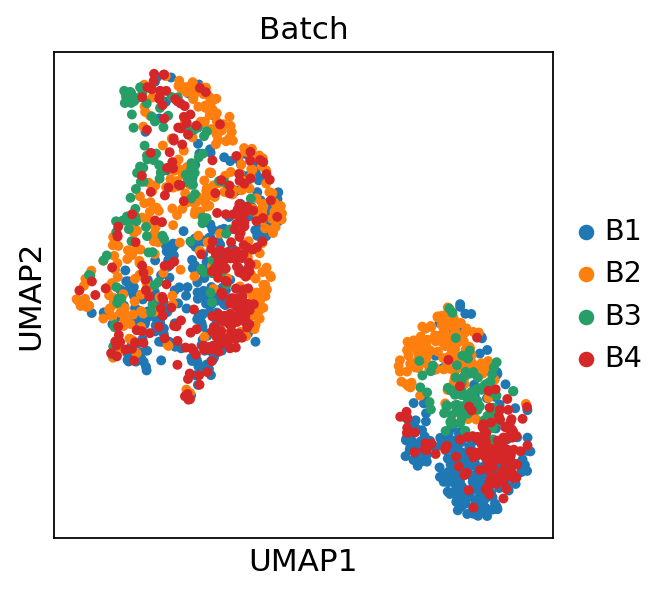

In [5]:
sc.pl.umap(adata, color='Batch')

In [6]:
network = scgen.VAEArith(x_dimension= adata.shape[1], model_path="./models/batch" )
network.train(train_data=adata, n_epochs=100)
corrected_adata =  scgen.batch_removal(network, adata, batch_key="Batch", cell_label_key="Cell_Type")
corrected_adata.write('./write/test.h5ad')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [203]:
corrected_adata = sc.read('./write/test.h5ad')

In [204]:
sc.tl.pca(corrected_adata, svd_solver='arpack')
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

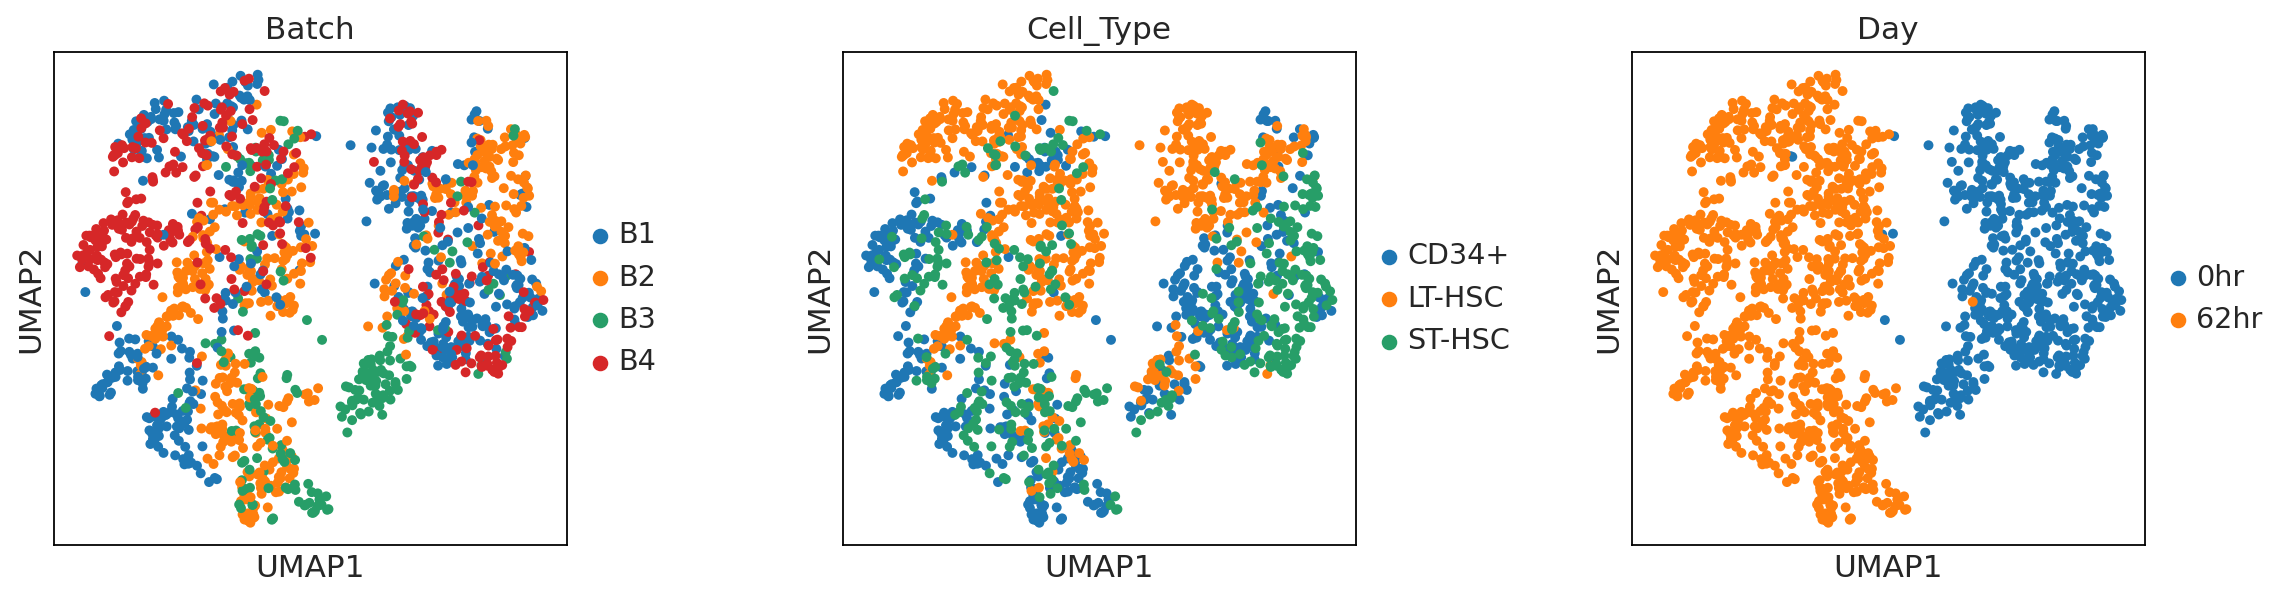

In [205]:
sc.pl.umap(corrected_adata, color=["Batch", "Cell_Type" , "Day"], wspace=.4)

# Batch correction separately

In [114]:
adata_day0 = adata[adata.obs['Day'] == '0hr'].copy()
adata_day3 = adata[adata.obs['Day'] == '62hr'].copy()

## Day0

In [ ]:
network = scgen.VAEArith(x_dimension= adata_day0.shape[1], model_path="./models/batch1" )
network.train(train_data=adata_day0, n_epochs=100)
corrected_adata =  scgen.batch_removal(network, adata_day0, batch_key="Batch", cell_label_key="Cell_Type")
corrected_adata.write('./write/test_day0.h5ad')

In [206]:
corrected_adata = sc.read('./write/test_day0.h5ad')
sc.tl.pca(corrected_adata, svd_solver='arpack')
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

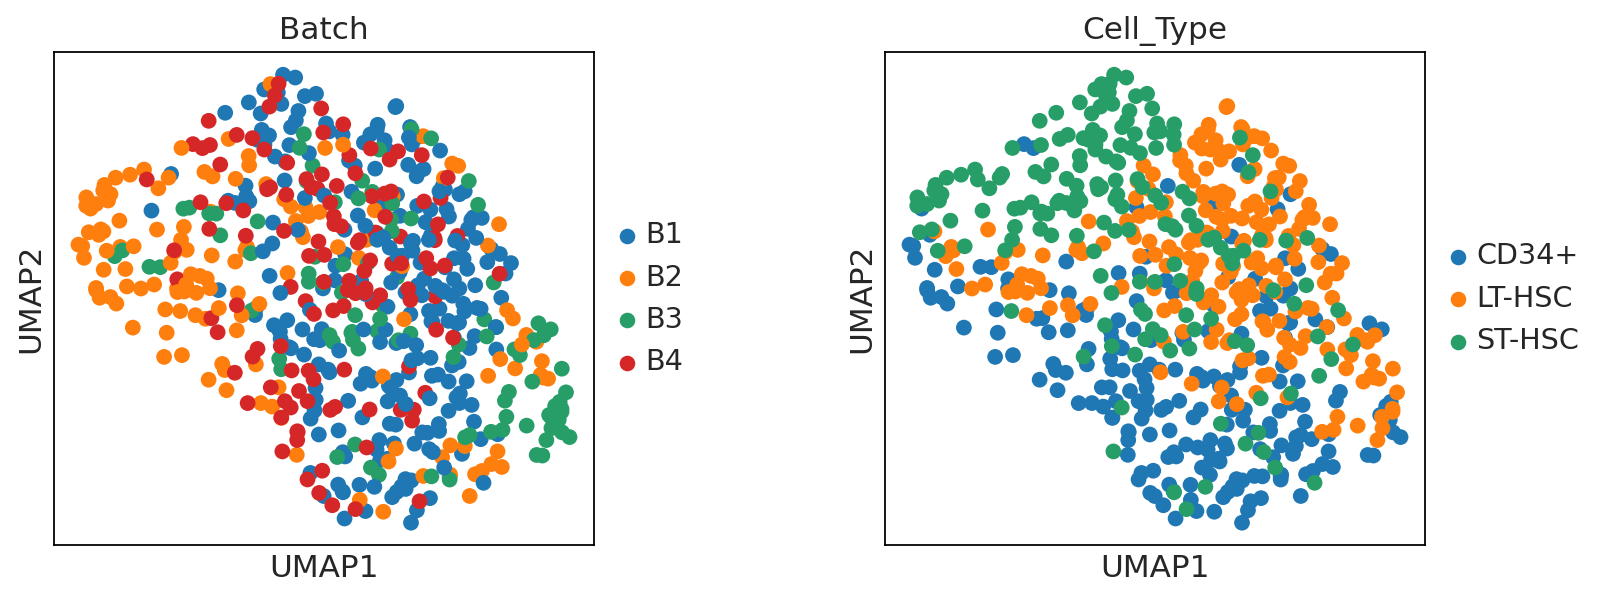

In [207]:
sc.pl.umap(corrected_adata, color=["Batch", "Cell_Type"], wspace=.4)

## Day3

In [92]:
network = scgen.VAEArith(x_dimension= adata_day3.shape[1], model_path="./models/batch2" )
network.train(train_data=adata_day3, n_epochs=100)
corrected_adata =  scgen.batch_removal(network, adata_day3, batch_key="Batch", cell_label_key="Cell_Type")
corrected_adata.write('./write/test_day3.h5ad')

In [208]:
corrected_adata = sc.read('./write/test_day3.h5ad')
sc.tl.pca(corrected_adata, svd_solver='arpack')
sc.pp.neighbors(corrected_adata)
sc.tl.umap(corrected_adata)

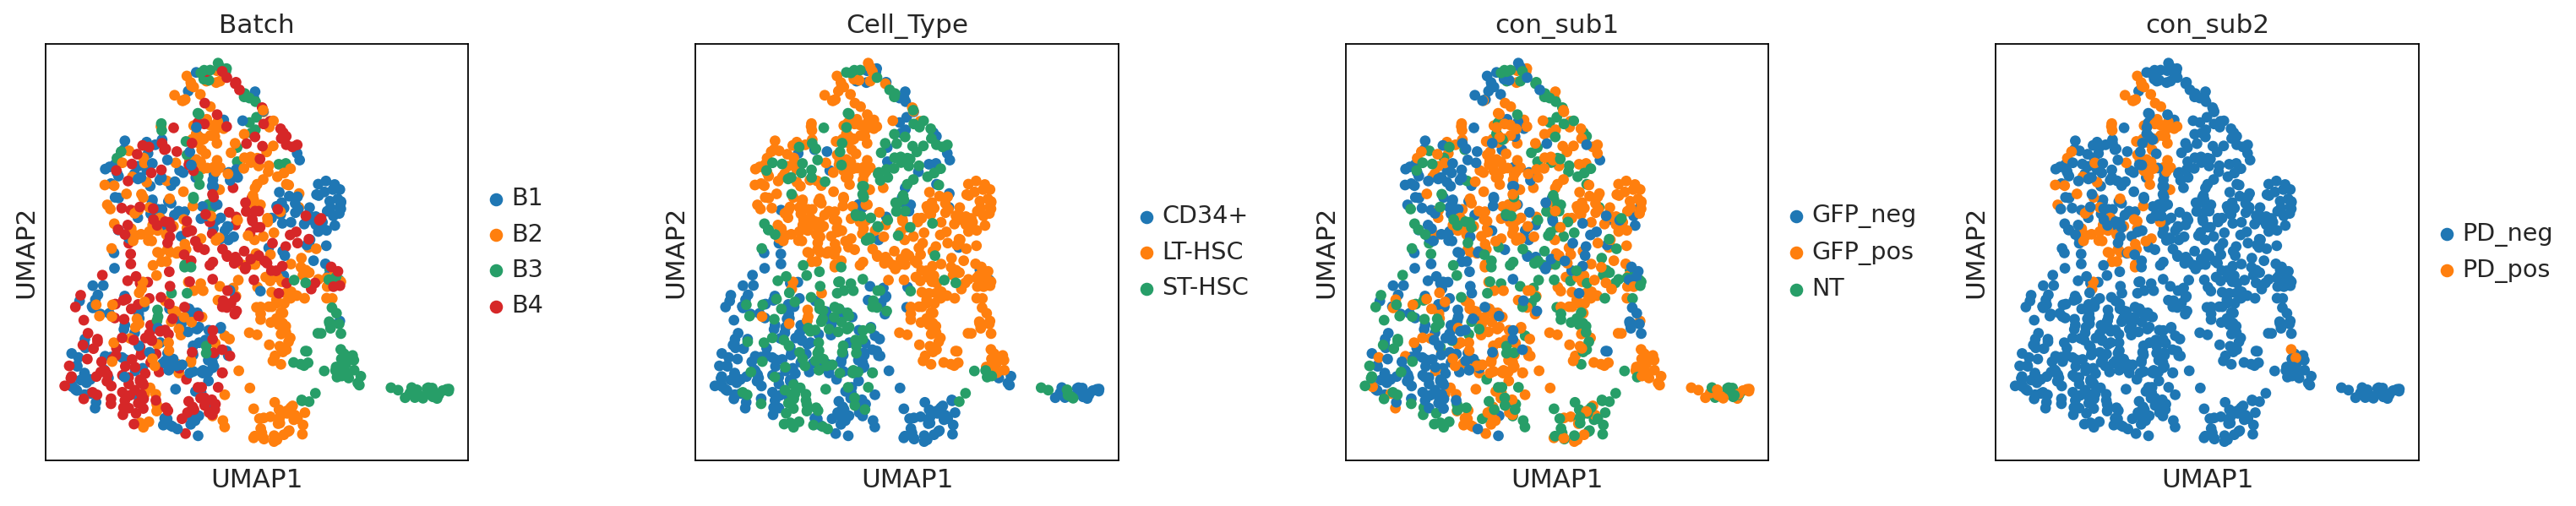

In [209]:
sc.pl.umap(corrected_adata, color=["Batch", "Cell_Type" ,'con_sub1', 'con_sub2'], wspace=.4)

# Quick validation

In [42]:
def validate_scGen(adata, ct, model_path = "./models/test1"):
    adata_sub1 = adata[~((adata.obs['con_sub1'] == 'GFP_pos') & (adata.obs['Cell_Type']==ct))]
    print(adata_sub1.obs['con_comb'].value_counts().sort_index())
    scg = scgen.VAEArith(x_dimension= adata_sub1.shape[1], model_path=model_path)
    scg.train(train_data=adata_sub1)
    ct_NT = adata[((adata.obs['con_sub1'] == 'NT') & (adata.obs['Cell_Type']==ct))]
    pred, delta = scg.predict(adata=adata_sub1, adata_to_predict=ct_NT,
                          conditions={"ctrl": "NT", "stim": "GFP_pos"}, cell_type_key="Cell_Type", condition_key="con_sub1")
    # look at all data
    pred_adata = sc.AnnData(pred, obs={"con_comb":["Day3_"+ct+"_GFP+PD-_pred"]*len(pred)}, var={"var_names":adata_sub1.var_names})
    all_adata = adata.concatenate(pred_adata)
    all_adata.obs['con_comb'] = all_adata.obs['con_comb'].astype('category')
    all_adata.obs['con_comb'] = all_adata.obs['con_comb'].cat.reorder_categories(['Day3_CD34+_GFP+PD-', 'Day3_CD34+_NT',
                                                                                 'Day3_LT-HSC_GFP+PD-', 'Day3_LT-HSC_NT',
                                                                                 'Day3_ST-HSC_GFP+PD-', 'Day3_ST-HSC_NT',
                                                                                 'Day3_'+ct+'_GFP+PD-_pred'])
    all_adata.uns['con_comb_colors'] = ['#2852c1', '#bcc9ea', '#970c32', '#f794af', '#006f02','#00d459', '#000000']
    sc.tl.pca(all_adata)
    sc.pp.neighbors(all_adata)
    sc.tl.umap(all_adata)
    sc.pl.umap(all_adata, color=['Batch','con_comb'], wspace = 0.3)
    del pred_adata
    del all_adata
    
    # look at the genes
    pred_adata = sc.AnnData(pred, obs={"con_sub1":["pred"]*len(pred)}, var={"var_names":adata_sub1.var_names})
    ctData = adata[adata.obs['Cell_Type']==ct]
    all_adata = ctData.concatenate(pred_adata)
    sc.tl.rank_genes_groups(ctData, groupby="con_sub1")
    diff_genes = ctData.uns["rank_genes_groups"]["names"]["GFP_pos"]
    print(diff_genes)
    r2_value = scgen.plotting.reg_mean_plot(all_adata, condition_key="con_sub1",
                                        axis_keys={
                                            "x": "pred", "y": "GFP_pos"},
                                        gene_list=diff_genes[:10],
                                        labels={"x": "predicted",
                                                "y": "ground truth"},
                                        #path_to_save="./reg_mean1.pdf",
                                        show=True,
                                        legend=False)

In [107]:
adata_day3 = sc.read('./write/test_day3.h5ad')
idx = ((adata_day3.obs['con_sub1'] != 'GFP_neg') & (adata_day3.obs['con_sub2']!='PD_pos'))
adata_day3 = adata_day3[idx]

Day3_CD34+_GFP+PD-     112
Day3_CD34+_NT           97
Day3_LT-HSC_NT          75
Day3_ST-HSC_GFP+PD-     94
Day3_ST-HSC_NT          71
Name: con_comb, dtype: int64


... storing 'Batch' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Cell_Type' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Condition' as categorical
... storing 'Day' as categorical
... storing 'Details' as categorical
... storing 'FACs_index_data' as categorical
... storing 'Gottgens_ID_RBGxxx' as categorical
... storing 'ID' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Owner' as categorical
... storing 'Plate' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_RNA_seq' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Sample_name' as categorical
... storing 'Species' as categorical
... storing 'con_sub1' as categorical
... storing 'con_sub2' as categorical
... storing 'phase'

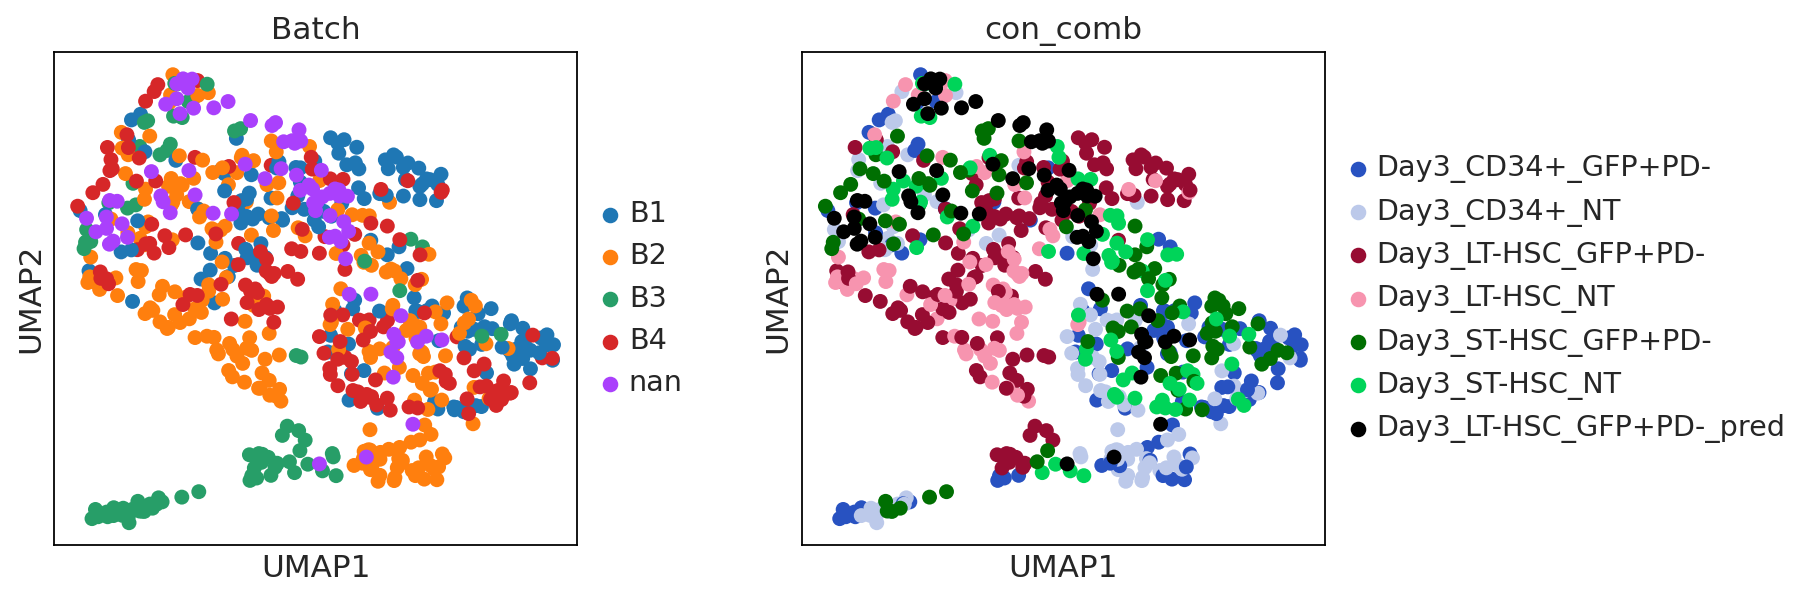

Trying to set attribute `.uns` of view, copying.


['CTC-546K23.2' 'HLA-DQB2-7' 'KTI12' 'ILF3-AS1' 'TSR2' 'THOC6' 'C12orf10'
 'PYCR1' 'RP11-1000B6.3' 'S100A7A' 'NOSIP' 'DNTTIP1' 'RP11-328J14.2'
 'MT1G' 'RP11-566K19.6' 'YAE1D1' 'HARBI1' 'CDC25C' 'F12' 'SNUPN' 'FAM174A'
 'FICD' 'CSDAP1' 'NDC80' 'RP11-417P24.1' 'CPA3' 'ZNF302' 'TBXAS1' 'ROGDI'
 'RPAIN' 'PGDP1' 'RP11-134K1.2' 'RP11-75A9.1' 'PCBP1-AS1' 'THAP3' 'NPRL3'
 'SKA1' 'RAB30' 'CD2BP2' 'S100Z' 'ASH1L-AS1' 'TMEM199' 'MIIP' 'BEND3'
 'ACOT4' 'TMEM98' 'LIN7B' 'BANF1P3' 'SENCR' 'RP3-406A7.5' 'NDRG2' 'FAAP20'
 'POLR2J4-1' 'MUS81' 'CRADD' 'PHOSPHO2' 'ITGA2B' 'C19orf25' 'IL3RA'
 'MED27' 'RP6-159A1.4' 'ANLN' 'DDX56' 'CINP' 'RP11-999E24.3' 'RAB21'
 'MTX2' 'SPTLC1' 'SNHG11' 'CTNNBL1' 'POLE4' 'SLC48A1' 'TIMP3' 'KDM6A'
 'STK19' 'TIMM17B' 'DCTN6' 'RAB1C' 'RP1-261D10.1' 'MRPS21P6' 'PDZD11'
 'PKIG' 'CENPT' 'ZMAT5' 'PQBP1' 'AC115617.2' 'RP11-407N17.6'
 'RP11-620J15.3' 'HHLA3' 'RP11-333E13.4' 'CTD-2353F22.1' 'INAFM1' 'BAIAP2'
 'TVP23CP2' 'MT1XP1' 'EMC9' 'HMOX2' 'C16orf45' 'C17orf62' 'NTAN1P2']


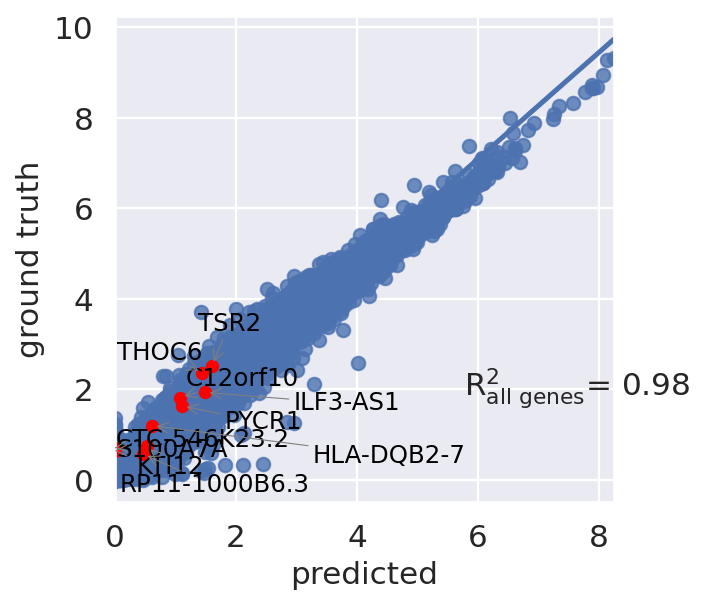

In [108]:
validate_scGen(adata_day3, 'LT-HSC', model_path = "./models/test1")

Day3_CD34+_GFP+PD-     112
Day3_CD34+_NT           97
Day3_LT-HSC_GFP+PD-    143
Day3_LT-HSC_NT          75
Day3_ST-HSC_NT          71
Name: con_comb, dtype: int64


... storing 'Batch' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Cell_Type' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Condition' as categorical
... storing 'Day' as categorical
... storing 'Details' as categorical
... storing 'FACs_index_data' as categorical
... storing 'Gottgens_ID_RBGxxx' as categorical
... storing 'ID' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Owner' as categorical
... storing 'Plate' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_RNA_seq' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Sample_name' as categorical
... storing 'Species' as categorical
... storing 'con_sub1' as categorical
... storing 'con_sub2' as categorical
... storing 'phase'

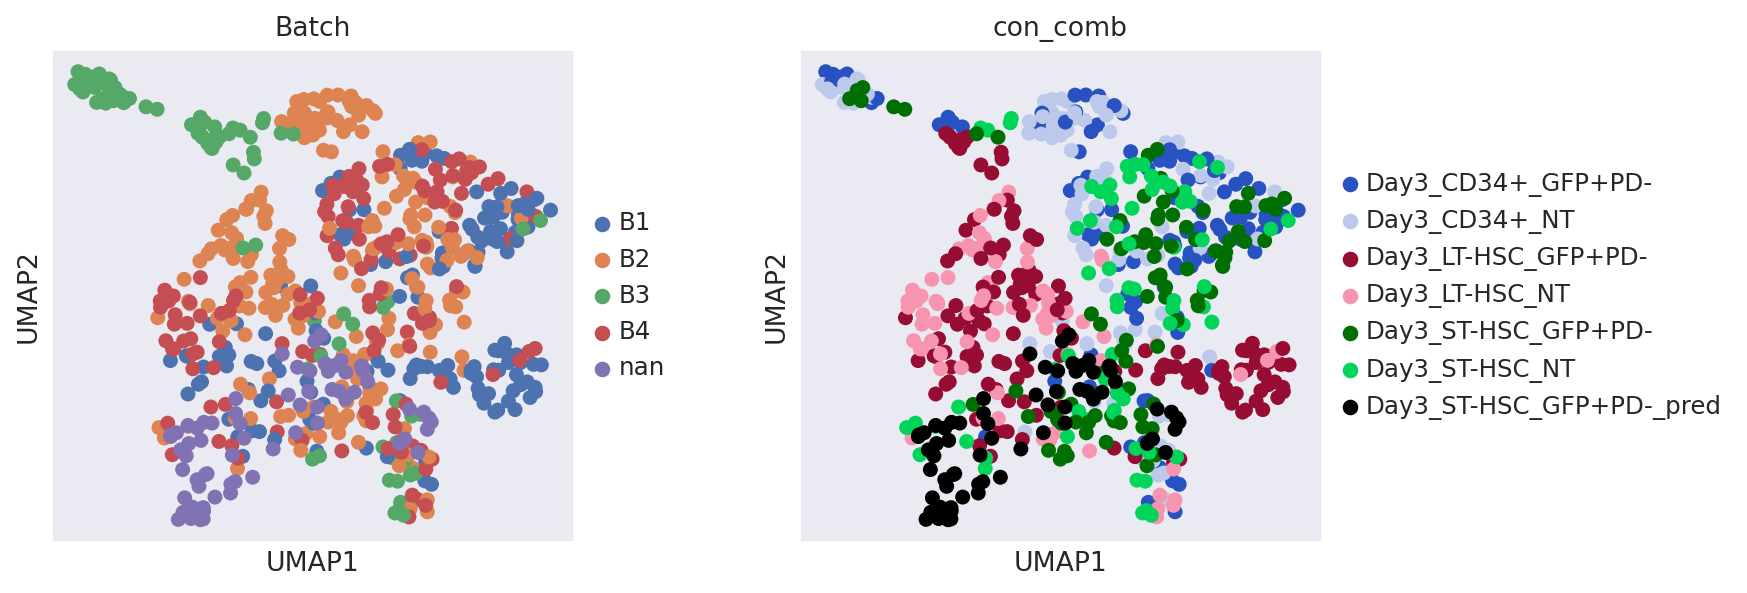

Trying to set attribute `.uns` of view, copying.


['RP11-363H12.1' 'CHCHD2P9' 'AC104978.1' 'SNRPGP15' 'RPS15AP40' 'RNF7P1'
 'RPEL1' 'MRPL23' 'PRELID1P1' 'RP11-568J23.1' 'PYCR1' 'BOLA2P1'
 'PITPNA-AS1' 'FAM98C' 'AC002056.3' 'EIF4A1P1' 'RP11-396C23.3' 'TIMM8BP2'
 'TATDN1P1' 'C12orf45' 'ZNHIT3' 'RILP' 'COA1' 'FUOM' 'SRA1' 'PXN-AS1'
 'RP1-96H9.5' 'RP11-378G13.2' 'COA4' 'TIMM17A' 'RP11-358M11.4'
 'CTD-2384B9.1' 'RER1' 'TATDN1' 'RP11-395P16.1' 'AC108059.1' 'QPRT'
 'RP11-393N4.2' 'BOLA2B' 'RPL35P1' 'PPIAP31' 'GALE' 'SUPT4H1P' 'EXOSC1'
 'CDK5PS' 'VPS25' 'LAGE3P1' 'BST1' 'RP11-395L14.17' 'RP3-375P9.2' 'CDK5'
 'CKB' 'MRPL12' 'AEN' 'SSH3' 'UMPS' 'RP11-331F4.1' 'MEA1' 'AC007229.3'
 'SMIM12' 'ATP5G1P7' 'MTX1' 'URM1' 'DPCD' 'RP1-179N16.3' 'RP11-5O23.1'
 'MRPL24' 'BID' 'HSPE1P2' 'POP7' 'BANF1P3' 'RP11-697N18.2' 'ASNA1' 'PINX1'
 'MED11' 'AC073465.1' 'SUMO1P4' 'FXNP2' 'RP11-20O24.4' 'KDELC1' 'BCAS2'
 'ATP5G1P5' 'BANF1P4' 'RNPS1P1' 'FAM229B' 'GAMT' 'NUTF2P4' 'RP11-69L16.3'
 'DOK4' 'SLC25A17' 'RP11-452D12.1' 'CHRNB1' 'RPL7P1' 'SDHCP4' 'S100A7A'
 'RP11-5

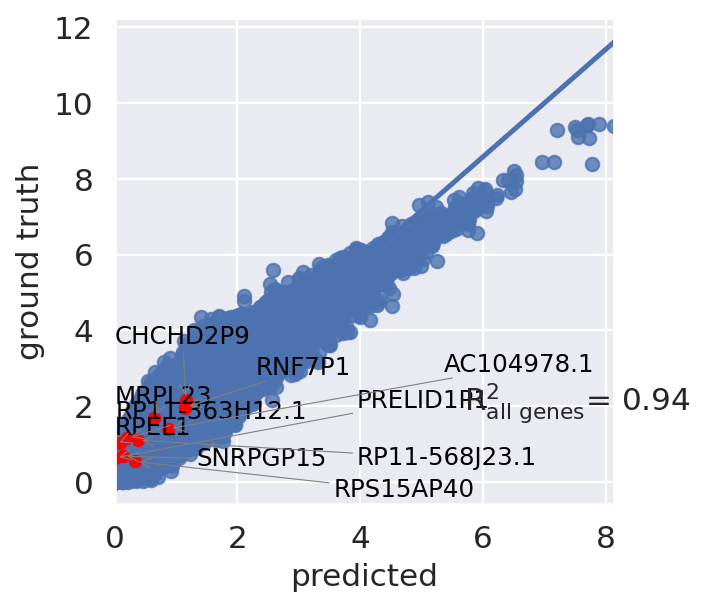

In [109]:
validate_scGen(adata_day3, 'ST-HSC', model_path = "./models/test2")

Day3_CD34+_NT           97
Day3_LT-HSC_GFP+PD-    143
Day3_LT-HSC_NT          75
Day3_ST-HSC_GFP+PD-     94
Day3_ST-HSC_NT          71
Name: con_comb, dtype: int64


... storing 'Batch' as categorical
... storing 'CI_annotation_of_index' as categorical
... storing 'CRI_identifier' as categorical
... storing 'CRI_run' as categorical
... storing 'Cell_Type' as categorical
... storing 'Cell_type_general' as categorical
... storing 'Cell_type_subtype' as categorical
... storing 'Condition' as categorical
... storing 'Day' as categorical
... storing 'Details' as categorical
... storing 'FACs_index_data' as categorical
... storing 'Gottgens_ID_RBGxxx' as categorical
... storing 'ID' as categorical
... storing 'Index_name_in_library_Set' as categorical
... storing 'Owner' as categorical
... storing 'Plate' as categorical
... storing 'Plate_number' as categorical
... storing 'Position_in_96_well_plate_RNA_seq' as categorical
... storing 'Position_in_96_well_plate_sorted' as categorical
... storing 'Sample_name' as categorical
... storing 'Species' as categorical
... storing 'con_sub1' as categorical
... storing 'con_sub2' as categorical
... storing 'phase'

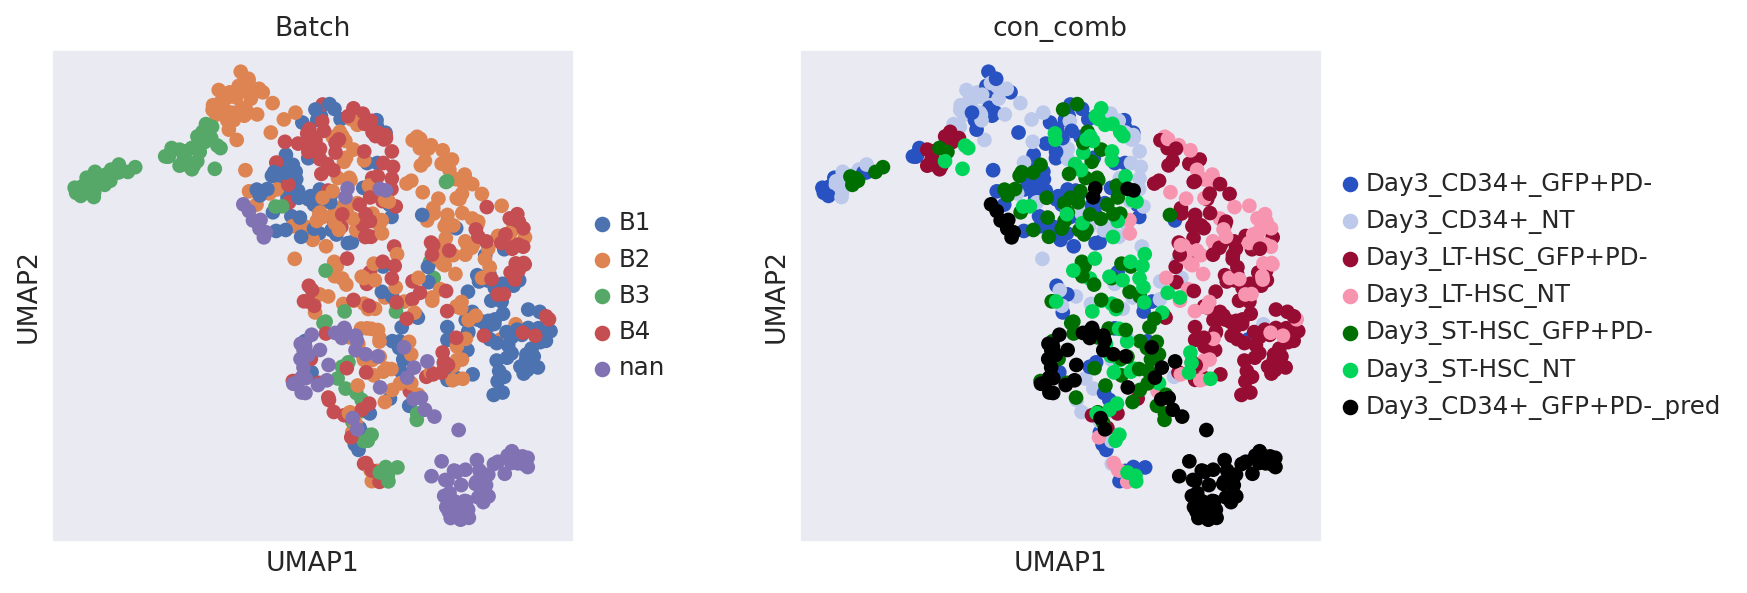

Trying to set attribute `.uns` of view, copying.


['HES1' 'FREM1' 'FCER1A' 'RP11-398K22.12' 'FKBP1B' 'CMTM5' 'HBD' 'KLF1'
 'RP11-216N14.7' 'GATA1' 'ELL2' 'RP11-451H23.1' 'SIGLEC14' 'TIMP3'
 'MFSD2B' 'RP11-354E11.2' 'ZNF385A' 'FCGR2A' 'CSF2RB' 'HPGD' 'CPQ' 'TFR2'
 'ITGA2B' 'KCNK6' 'CD36' 'CPA3' 'PLK3' 'SMN1' 'HBQ1' 'CNRIP1' 'RAB6B'
 'ADCK1' 'UEVLD' 'CDKL1' 'ZNF787' 'TPSAB1' 'RP5-1120P11.1' 'RP11-344P13.3'
 'ZNF768' 'ZSCAN29' 'OR14L1P' 'PITPNA-AS1' 'LINC00863' 'LENG1'
 'RP11-678G14.3' 'FAM83D' 'DUSP1' 'STK17A' 'SMAD9' 'TPSB2' 'ARHGAP18'
 'TPSD1' 'ADRA2A' 'CXCL8' 'MICAL2' 'RGS1' 'DOK2' 'SLC4A8' 'FAM24B'
 'DNAJC6' 'DLC1' 'AKAP2' 'FAM98C' 'FCER1G' 'RP11-444B24.2' 'TUBB6' 'HBB'
 'AMMECR1' 'OGFRL1' 'PVRL1' 'CPOX' 'IQCE' 'PMP22' 'CTBP2P8' 'JMJD4' 'UGCG'
 'GOLM1' 'FDXR' 'PEX11A' 'ZNF684' 'RP11-178H8.3' 'AC147651.4' 'XK' 'ABCB8'
 'SLC7A5' 'KCNH2' 'RP11-472F19.1' 'MAP4K4' 'SLA2' 'CTTNBP2' 'RAB39B'
 'FTLP17' 'SSH3' 'WDR82P1' 'GP9' 'U1-29' 'KIF2C' 'FHL2' 'AC012512.1' 'PGP']


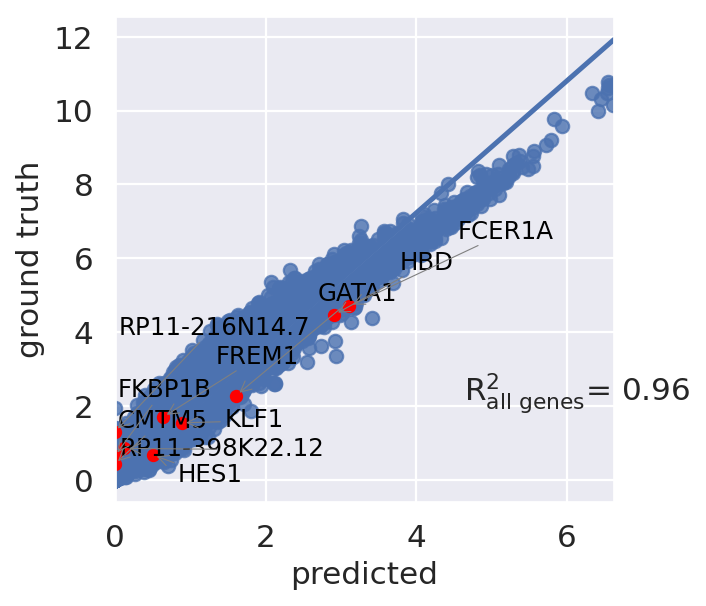

In [110]:
validate_scGen(adata_day3, 'CD34+', model_path = "./models/test3")

# Cross Study Test

In [3]:
adata_day3 = sc.read('./write/test_day3.h5ad')
idx = ((adata_day3.obs['con_sub1'] != 'GFP_neg') & (adata_day3.obs['con_sub2']!='PD_pos'))
adata_day3 = adata_day3[idx]
print(adata_day3.shape)

adata_day0 = sc.read('./write/test_day0.h5ad')
print(adata_day0.shape)

(592, 49325)
(598, 49325)


In [188]:
scg = scgen.VAEArith(x_dimension=adata_day0.shape[1], z_dimension=100, model_path="./models/crossStudy")
scg.train(train_data=adata_day3)

In [189]:
pred, delta = scg.predict(adata=adata_day3, adata_to_predict=adata_day0,
                          conditions={"ctrl": "NT", "stim": "GFP_pos"}, cell_type_key="Cell_Type", condition_key="con_sub1")

In [190]:
pred_adata = sc.AnnData(pred, obs={"obs_names": adata_day0.obs_names, "con_comb":(adata_day0.obs['Cell_Type'].astype(str)+'_pred').values}, var={"var_names":adata_day0.var_names})
all_adata = adata_day3.concatenate([adata_day0,pred_adata])

In [191]:
sc.tl.pca(all_adata)
sc.pp.neighbors(all_adata)
sc.tl.umap(all_adata)

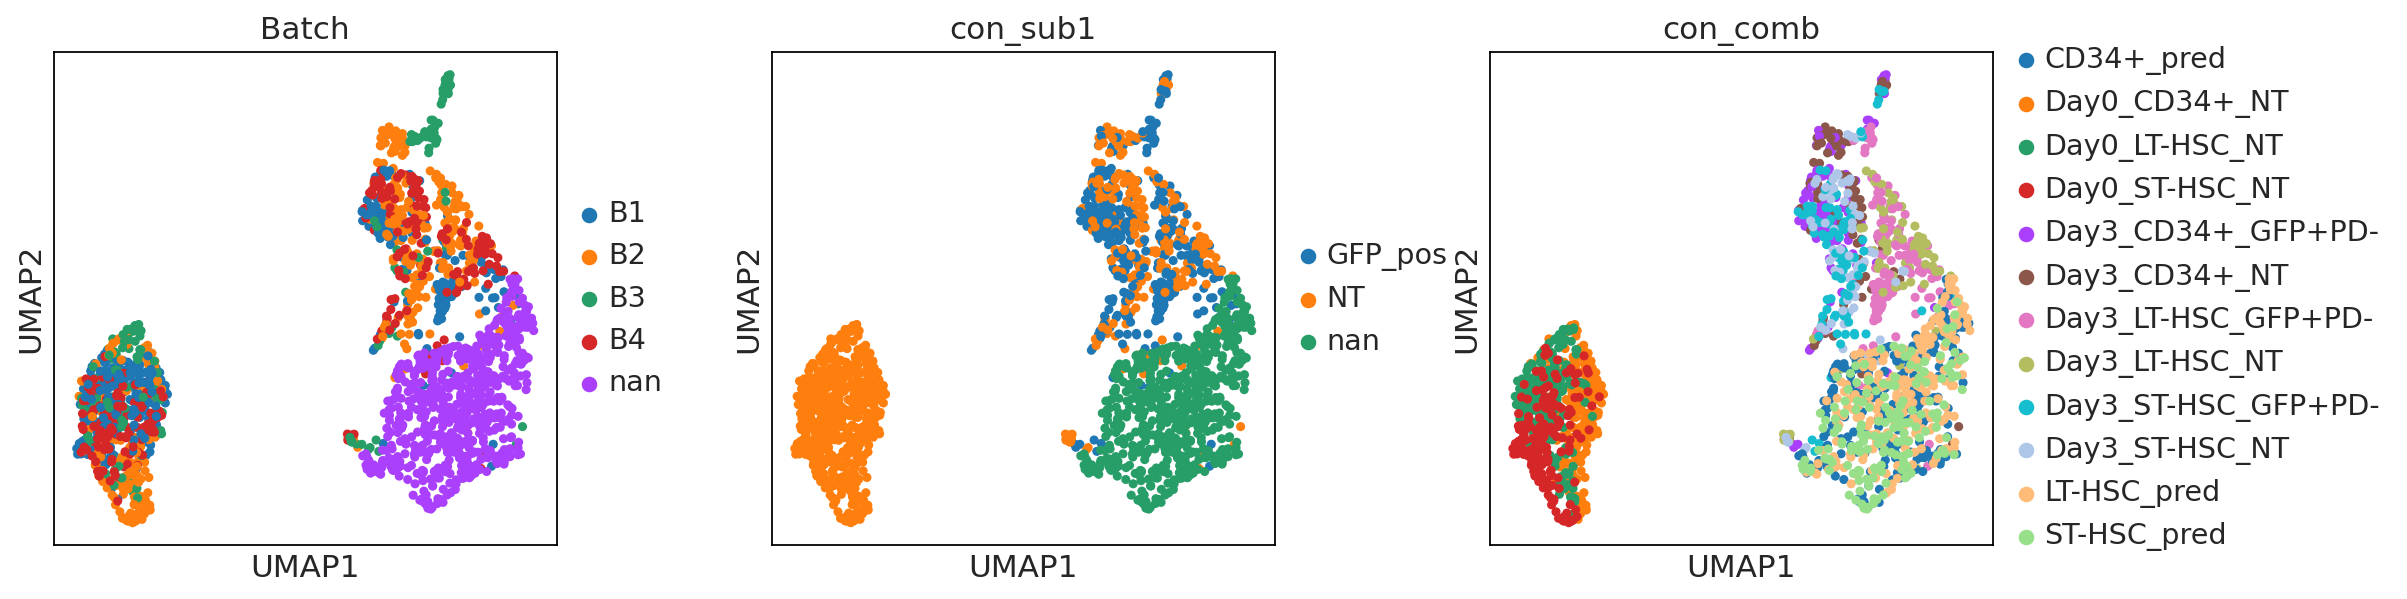

In [196]:
sc.pl.umap(all_adata, color=['Batch', 'con_sub1','con_comb'], wspace = 0.3)

In [197]:
sc.tl.rank_genes_groups(all_adata, groupby="batch", reference='1', groups=['2'], n_genes=adata_day0.shape[1])

In [198]:
all_adata.uns['rank_genes_groups']['names']['2'][0:10]

array(['S100A11P1', 'C14orf119', 'RP1-152L7.8', 'C1GALT1C1', 'C10orf128',
       'MRPL14', 'RP11-343B5.1', 'RP5-827C21.1', 'RP11-795H16.2',
       'RP11-421L21.3'], dtype='<U50')

In [199]:
gidx = np.where(all_adata.uns['rank_genes_groups']['names']['2'] == 'S100A7A')[0]
print(gidx)

[168]


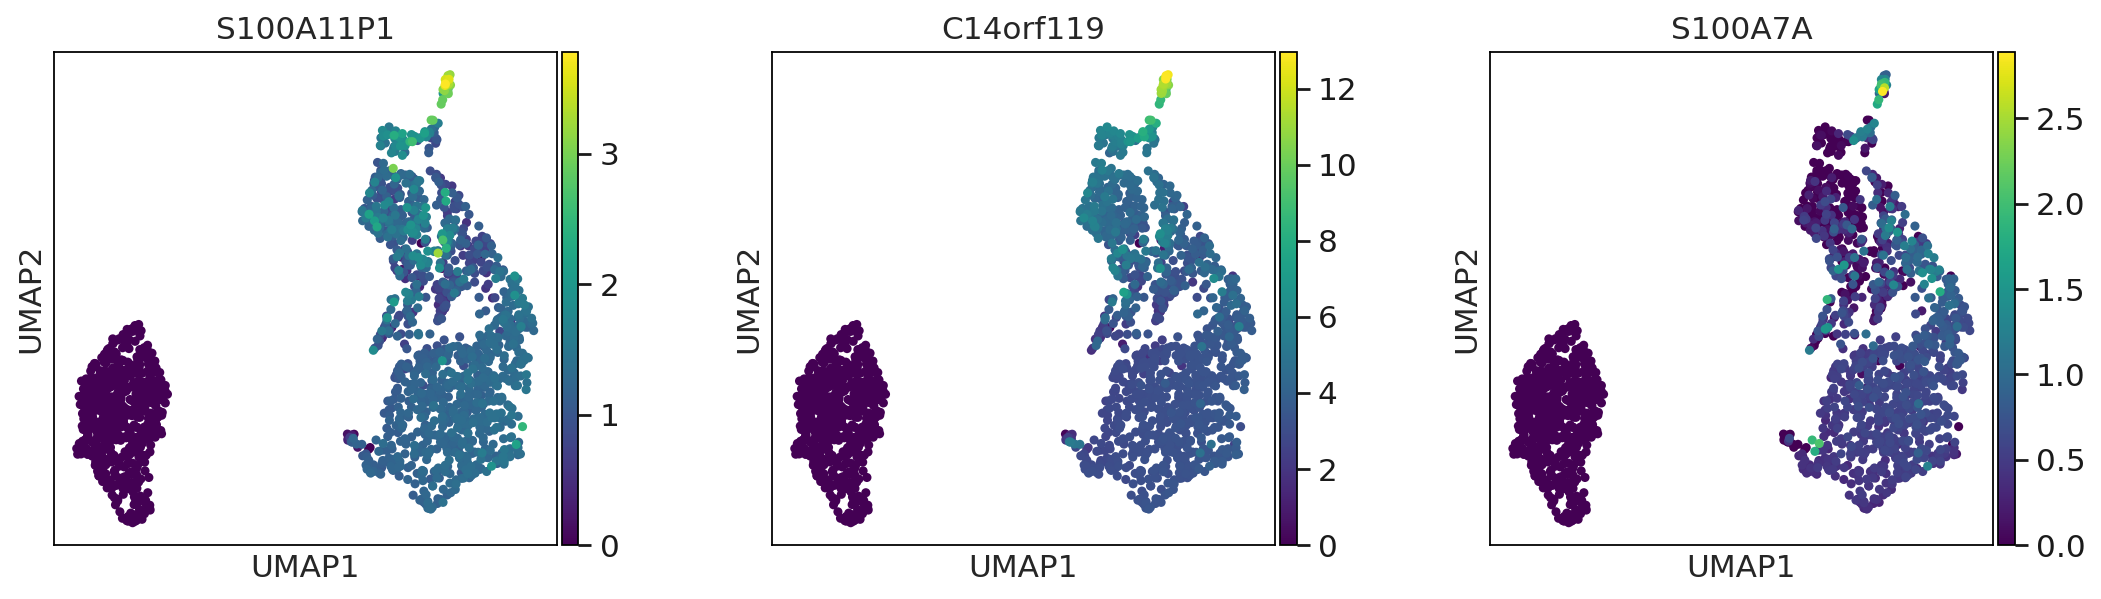

In [201]:
sc.pl.umap(all_adata, color=['S100A11P1','C14orf119','S100A7A'], wspace = 0.3)

In [202]:
all_adata.write('./write/test_crossStudy.h5ad')